In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
sns.set()

In [2]:
data_dir = "data"
train_fn = "train.csv"
test_fn = "test.csv"
train_path = os.path.join(data_dir, train_fn)
test_path = os.path.join(data_dir, test_fn)

In [19]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [134]:
train_data = pd.read_csv(train_path)

In [80]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [81]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [82]:
# Get the numnber of occurances of each operator
survived_counts = train_data.Survived.value_counts()

# Split and Save the Operator names in a variable
ids = survived_counts.index

# Split and Save the counts in another variable
counts = survived_counts.get_values()

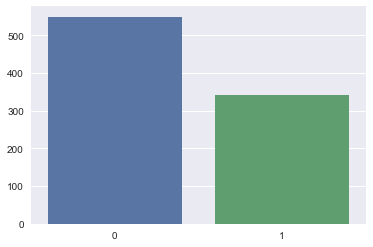

In [83]:
# Create barplot object
barplot = sns.barplot(x=ids, y=counts)

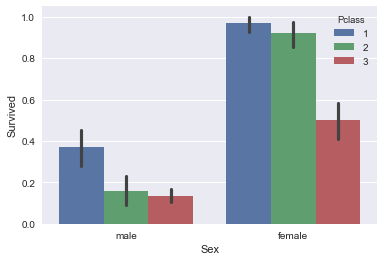

In [84]:
sns.barplot(x="Sex", y="Survived", hue="Pclass", data=train_data)

In [85]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [86]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [87]:
train_data_num = train_data.select_dtypes(include=[np.number])

In [88]:
train_data_num.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [89]:
train_data_num = train_data_num.drop(['PassengerId', 'Survived'], axis=1)

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

train_data_num_tr = num_pipeline.fit_transform(train_data_num)

In [91]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].astype(str).values

In [159]:
num_attribs = list(train_data_num)
cat_attribs = ["Sex", "Ticket", "Cabin", "Embarked"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense", handle_unknown='ignore')),
    ])

In [93]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [135]:
train_labels = train_data['Survived']
train_data = train_data.drop(['PassengerId', 'Survived', 'Name'], axis=1)

In [101]:
train_labels.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [102]:
train_labels.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [95]:
train_data.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')

In [160]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [161]:
train_data_prepared = full_pipeline.fit_transform(train_data)

In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_clf = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                           scoring='f1')
grid_search.fit(train_data_prepared, train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [104]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [105]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [107]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.684806015988 {'max_features': 2, 'n_estimators': 3}
0.736610044032 {'max_features': 2, 'n_estimators': 10}
0.754547262562 {'max_features': 2, 'n_estimators': 30}
0.713836811486 {'max_features': 4, 'n_estimators': 3}
0.744265807066 {'max_features': 4, 'n_estimators': 10}
0.761161665835 {'max_features': 4, 'n_estimators': 30}
0.697962116154 {'max_features': 6, 'n_estimators': 3}
0.734903390976 {'max_features': 6, 'n_estimators': 10}
0.762573126139 {'max_features': 6, 'n_estimators': 30}
0.701281800045 {'max_features': 8, 'n_estimators': 3}
0.758282632694 {'max_features': 8, 'n_estimators': 10}
0.763070413936 {'max_features': 8, 'n_estimators': 30}
0.708705276748 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.729931300056 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.720676651492 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.734713835081 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
0.705718084114 {'bootstrap': False, 'max_featu

In [108]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30, 50, 70, 90, 110], 'max_features': [2, 4, 6, 8, 10, 12, 14]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10, 20], 'max_features': [2, 3, 4, 5, 6]},
  ]

forest_clf = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                           scoring='f1')
grid_search.fit(train_data_prepared, train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30, 50, 70, 90, 110], 'max_features': [2, 4, 6, 8, 10, 12, 14]}, {'bootstrap': [False], 'n_estimators': [3, 10, 20], 'max_features': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [109]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 90}

In [110]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [111]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.684806015988 {'max_features': 2, 'n_estimators': 3}
0.736610044032 {'max_features': 2, 'n_estimators': 10}
0.754547262562 {'max_features': 2, 'n_estimators': 30}
0.757640838526 {'max_features': 2, 'n_estimators': 50}
0.767512665335 {'max_features': 2, 'n_estimators': 70}
0.765727947722 {'max_features': 2, 'n_estimators': 90}
0.766990450904 {'max_features': 2, 'n_estimators': 110}
0.713836811486 {'max_features': 4, 'n_estimators': 3}
0.744265807066 {'max_features': 4, 'n_estimators': 10}
0.761161665835 {'max_features': 4, 'n_estimators': 30}
0.765707342983 {'max_features': 4, 'n_estimators': 50}
0.771194817591 {'max_features': 4, 'n_estimators': 70}
0.768273248379 {'max_features': 4, 'n_estimators': 90}
0.770056330061 {'max_features': 4, 'n_estimators': 110}
0.697962116154 {'max_features': 6, 'n_estimators': 3}
0.734903390976 {'max_features': 6, 'n_estimators': 10}
0.762573126139 {'max_features': 6, 'n_estimators': 30}
0.778814636024 {'max_features': 6, 'n_estimators': 50}
0.781543613

In [112]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_clf = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(forest_clf, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='accuracy', random_state=42)
rnd_search.fit(train_data_prepared, train_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000014240C53080>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000014240C53D68>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

In [114]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.83950617284 {'max_features': 7, 'n_estimators': 180}
0.826038159371 {'max_features': 5, 'n_estimators': 15}
0.838383838384 {'max_features': 3, 'n_estimators': 72}
0.83164983165 {'max_features': 5, 'n_estimators': 21}
0.838383838384 {'max_features': 7, 'n_estimators': 122}
0.835016835017 {'max_features': 3, 'n_estimators': 75}
0.836139169473 {'max_features': 3, 'n_estimators': 88}
0.824915824916 {'max_features': 5, 'n_estimators': 100}
0.840628507295 {'max_features': 3, 'n_estimators': 150}
0.775533108866 {'max_features': 5, 'n_estimators': 2}


In [115]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([  3.80437112e-02,   7.35877463e-02,   2.57078056e-02,
         2.18368720e-02,   8.02606407e-02,   9.62072028e-02,
         8.42021424e-02,   1.17665123e-03,   5.50302883e-04,
         7.10663411e-04,   9.58327156e-04,   1.90562617e-04,
         3.40436975e-04,   2.83434385e-04,   6.53137086e-04,
         7.94045936e-04,   1.38034809e-03,   1.83799908e-03,
         1.60298259e-03,   2.28615841e-04,   2.10872829e-04,
         4.60209010e-04,   2.60521202e-04,   2.49341075e-04,
         5.98694702e-04,   3.30217072e-04,   2.04647808e-04,
         2.68176368e-04,   3.17110633e-04,   3.67138784e-04,
         6.89740979e-04,   2.89223577e-04,   4.65425179e-04,
         4.26904018e-04,   3.03014838e-04,   7.04241263e-04,
         4.89710223e-04,   2.66376358e-04,   1.55622163e-04,
         4.66989567e-04,   1.60133248e-03,   3.04734603e-04,
         3.17257030e-04,   3.68789632e-04,   1.88035031e-03,
         4.48987786e-04,   2.63831385e-04,   7.70285425e-04,
         2.58571124e-04,

In [117]:
num_attribs

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [119]:
list(cat_encoder.categories_[0])

['female', 'male']

In [116]:
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.096207202849624973, 'female'),
 (0.084202142430869792, 'male'),
 (0.080260640743907097, 'Fare'),
 (0.073587746250216551, 'Age'),
 (0.038043711197780189, 'Pclass'),
 (0.025707805566393748, 'SibSp'),
 (0.021836871981943964, 'Parch')]

Now some DL

In [137]:
import tensorflow as tf

config = tf.contrib.learn.RunConfig(tf_random_seed=42) # not shown in the config

feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(train_data_prepared)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300,100], n_classes=2,
                                         feature_columns=feature_cols, config=config)
dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # if TensorFlow >= 1.1
dnn_clf.fit(train_data_prepared, train_labels, batch_size=50, steps=20000)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000142FF6A2DD8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\SAMSEP~1\\AppData\\Local\\Temp\\tmpb43ef47k'}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer sup

INFO:tensorflow:global_step/sec: 265.888
INFO:tensorflow:loss = 0.0156593, step = 6501 (0.376 sec)
INFO:tensorflow:global_step/sec: 256.412
INFO:tensorflow:loss = 0.00261877, step = 6601 (0.390 sec)
INFO:tensorflow:global_step/sec: 258.616
INFO:tensorflow:loss = 0.000441592, step = 6701 (0.387 sec)
INFO:tensorflow:global_step/sec: 243.692
INFO:tensorflow:loss = 0.0294845, step = 6801 (0.410 sec)
INFO:tensorflow:global_step/sec: 258.733
INFO:tensorflow:loss = 0.0072922, step = 6901 (0.386 sec)
INFO:tensorflow:global_step/sec: 218.466
INFO:tensorflow:loss = 0.039301, step = 7001 (0.459 sec)
INFO:tensorflow:global_step/sec: 217.554
INFO:tensorflow:loss = 0.000327751, step = 7101 (0.459 sec)
INFO:tensorflow:global_step/sec: 237.548
INFO:tensorflow:loss = 0.000248132, step = 7201 (0.420 sec)
INFO:tensorflow:global_step/sec: 255.841
INFO:tensorflow:loss = 0.00521558, step = 7301 (0.391 sec)
INFO:tensorflow:global_step/sec: 263.153
INFO:tensorflow:loss = 0.00415564, step = 7401 (0.380 sec)
IN

INFO:tensorflow:loss = 0.00014846, step = 14601 (0.468 sec)
INFO:tensorflow:global_step/sec: 227.808
INFO:tensorflow:loss = 0.00017592, step = 14701 (0.438 sec)
INFO:tensorflow:global_step/sec: 226.253
INFO:tensorflow:loss = 0.000135205, step = 14801 (0.443 sec)
INFO:tensorflow:global_step/sec: 228.408
INFO:tensorflow:loss = 9.81083e-05, step = 14901 (0.437 sec)
INFO:tensorflow:global_step/sec: 230.994
INFO:tensorflow:loss = 0.00648775, step = 15001 (0.433 sec)
INFO:tensorflow:global_step/sec: 225.686
INFO:tensorflow:loss = 0.000469615, step = 15101 (0.443 sec)
INFO:tensorflow:global_step/sec: 234.599
INFO:tensorflow:loss = 0.00138795, step = 15201 (0.426 sec)
INFO:tensorflow:global_step/sec: 255.335
INFO:tensorflow:loss = 0.000235678, step = 15301 (0.391 sec)
INFO:tensorflow:global_step/sec: 245.248
INFO:tensorflow:loss = 0.0294764, step = 15401 (0.408 sec)
INFO:tensorflow:global_step/sec: 225.265
INFO:tensorflow:loss = 0.00112136, step = 15501 (0.444 sec)
INFO:tensorflow:global_step/

SKCompat()

In [153]:
test_data = pd.read_csv(test_path)

In [154]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [155]:
test_data.shape

(418, 11)

In [156]:
test_ids = test_data[['PassengerId', 'Name']]

In [157]:
test_data = test_data.drop(['PassengerId', 'Name'], axis=1)

In [162]:
test_data_prepared = full_pipeline.transform(test_data)

In [163]:
test_data_prepared.shape

(418, 840)

In [164]:
y_pred = dnn_clf.predict(test_data_prepared) #np.array([test_data[0]], dtype=float), as_iterable=False

INFO:tensorflow:Restoring parameters from C:\Users\SAMSEP~1\AppData\Local\Temp\tmpb43ef47k\model.ckpt-20000


In [175]:
preds = y_pred['classes']

In [181]:
preds.shape

(418,)

In [176]:
#set ids as PassengerId and predict survival 
ids = test_ids['PassengerId']

#set the output as a dataframe and convert to csv file named submission.csv
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': preds })
output.to_csv('submission.csv', index=False)

In [177]:
sub = pd.read_csv('submission.csv')

In [178]:
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [179]:
final_model = rnd_search.best_estimator_

final_predictions = final_model.predict(test_data_prepared)

In [180]:
final_predictions.shape

(418,)

In [182]:
#set the output as a dataframe and convert to csv file named submission.csv
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': final_predictions })
output.to_csv('submission_forest_clf.csv', index=False)